In [2]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
#생성자 모델
generator=Sequential()
generator.add(Dense(128*7*7, input_dim = 100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7,7,128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

In [7]:
#판별자
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False

In [9]:
#생성자와 판별자 모델을 연결시키는 gan모델
ginput= Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_1 (Sequential)   (None, 28, 28, 1)         865281    
                                                                 
 sequential_3 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [17]:
def gan_train(epoch, batch_size, saving_interval):
    (X_train, _), (_,_) = mnist.load_data()
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
    
    X_train = (X_train - 127.5)/127.5
    true = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for i in range(epoch):
        #실제 데이터를 판별자에 입력하는 부분
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        d_loss_real = discriminator.train_on_batch(imgs, true)
        
        #가상 이미지를 판별자에 입력하는 부분
        noise=np.random.normal(0,1,(batch_size, 100))
        gen_imgs = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        
        #판별자와 생성자의 오차를 계산
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        g_loss = gan.train_on_batch(noise, true)
        
        print('epoch:%d' %i, 'd_loss:%.4f' %d_loss, 'g_loss:%.4f' %g_loss)
        
        #중간과정을 이미지로 저장하는 부분
        #정해진 인터벌만큼 학습되면 그때 만든 이미지를 gan_images 폴더에 저장하라는 의미
        if i % saving_interval == 0:
        
            noise = np.random.normal(0,1,(25,100))
            gen_imgs = generator.predict(noise)

            gen_imgs = 0.5 * gen_imgs + 0.5

            fig, axs = plt.subplots(5,5)
            count = 0
            for j in range(5):
                for k in range(5):
                    axs[j,k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                    axs[j,k].axis('off')
                    count += 1
            fig.savefig("gan_images/gan_mnist_%d.png" %i)
            


1/1 [==============================] - 0s 149ms/step
epoch:0 d_loss:0.5064 g_loss:0.3231
1/1 [==============================] - 0s 66ms/step
epoch:1 d_loss:0.4431 g_loss:0.6606
1/1 [==============================] - 0s 65ms/step
epoch:2 d_loss:0.4350 g_loss:0.8813
1/1 [==============================] - 0s 75ms/step
epoch:3 d_loss:0.4203 g_loss:1.0606
1/1 [==============================] - 0s 68ms/step
epoch:4 d_loss:0.3775 g_loss:1.1639
1/1 [==============================] - 0s 66ms/step
epoch:5 d_loss:0.3603 g_loss:1.1686
1/1 [==============================] - 0s 65ms/step
epoch:6 d_loss:0.3934 g_loss:1.0778
1/1 [==============================] - 0s 69ms/step
epoch:7 d_loss:0.5355 g_loss:0.7806
1/1 [==============================] - 0s 67ms/step
epoch:8 d_loss:0.6483 g_loss:0.8030
1/1 [==============================] - 0s 78ms/step
epoch:9 d_loss:0.7311 g_loss:0.8556
1/1 [==============================] - 0s 80ms/step
epoch:10 d_loss:0.7078 g_loss:0.8236
1/1 [=========================

epoch:91 d_loss:0.4442 g_loss:4.1946
1/1 [==============================] - 0s 70ms/step
epoch:92 d_loss:0.5117 g_loss:3.7201
1/1 [==============================] - 0s 75ms/step
epoch:93 d_loss:0.7047 g_loss:3.3910
1/1 [==============================] - 0s 70ms/step
epoch:94 d_loss:0.6156 g_loss:3.7357
1/1 [==============================] - 0s 79ms/step
epoch:95 d_loss:1.0406 g_loss:3.1781
1/1 [==============================] - 0s 74ms/step
epoch:96 d_loss:0.9946 g_loss:2.3113
1/1 [==============================] - 0s 68ms/step
epoch:97 d_loss:1.0706 g_loss:2.2472
1/1 [==============================] - 0s 66ms/step
epoch:98 d_loss:0.9110 g_loss:2.2430
1/1 [==============================] - 0s 68ms/step
epoch:99 d_loss:0.8600 g_loss:1.6549
1/1 [==============================] - 0s 72ms/step
epoch:100 d_loss:0.8071 g_loss:1.7363
1/1 [==============================] - 0s 70ms/step
epoch:101 d_loss:0.7000 g_loss:2.0014
1/1 [==============================] - 0s 68ms/step
epoch:102 d_loss:0.

1/1 [==============================] - 0s 70ms/step
epoch:183 d_loss:0.3961 g_loss:1.9356
1/1 [==============================] - 0s 72ms/step
epoch:184 d_loss:0.5246 g_loss:1.5730
1/1 [==============================] - 0s 85ms/step
epoch:185 d_loss:0.4569 g_loss:1.6454
1/1 [==============================] - 0s 101ms/step
epoch:186 d_loss:0.4136 g_loss:1.5884
1/1 [==============================] - 0s 72ms/step
epoch:187 d_loss:0.4413 g_loss:1.5048
1/1 [==============================] - 0s 78ms/step
epoch:188 d_loss:0.4589 g_loss:1.5611
1/1 [==============================] - 0s 69ms/step
epoch:189 d_loss:0.5580 g_loss:1.3747
1/1 [==============================] - 0s 70ms/step
epoch:190 d_loss:0.3885 g_loss:1.6450
1/1 [==============================] - 0s 73ms/step
epoch:191 d_loss:0.4621 g_loss:1.6913
1/1 [==============================] - 0s 83ms/step
epoch:192 d_loss:0.4615 g_loss:1.7224
1/1 [==============================] - 0s 77ms/step
epoch:193 d_loss:0.4692 g_loss:1.6986
1/1 [====

1/1 [==============================] - 0s 77ms/step
epoch:273 d_loss:0.4979 g_loss:1.5839
1/1 [==============================] - 0s 72ms/step
epoch:274 d_loss:0.6969 g_loss:1.2988
1/1 [==============================] - 0s 73ms/step
epoch:275 d_loss:0.6478 g_loss:1.2599
1/1 [==============================] - 0s 72ms/step
epoch:276 d_loss:0.6242 g_loss:1.1839
1/1 [==============================] - 0s 76ms/step
epoch:277 d_loss:0.5513 g_loss:1.2688
1/1 [==============================] - 0s 74ms/step
epoch:278 d_loss:0.6174 g_loss:1.5603
1/1 [==============================] - 0s 73ms/step
epoch:279 d_loss:0.5211 g_loss:1.2906
1/1 [==============================] - 0s 73ms/step
epoch:280 d_loss:0.5885 g_loss:1.3068
1/1 [==============================] - 0s 78ms/step
epoch:281 d_loss:0.5982 g_loss:1.4850
1/1 [==============================] - 0s 73ms/step
epoch:282 d_loss:0.5398 g_loss:1.5345
1/1 [==============================] - 0s 113ms/step
epoch:283 d_loss:0.4414 g_loss:1.4458
1/1 [====

1/1 [==============================] - 0s 91ms/step
epoch:364 d_loss:0.4675 g_loss:1.8357
1/1 [==============================] - 0s 74ms/step
epoch:365 d_loss:0.5668 g_loss:1.2879
1/1 [==============================] - 0s 85ms/step
epoch:366 d_loss:0.6748 g_loss:1.3766
1/1 [==============================] - 0s 76ms/step
epoch:367 d_loss:0.5357 g_loss:1.4304
1/1 [==============================] - 0s 75ms/step
epoch:368 d_loss:0.4644 g_loss:1.8380
1/1 [==============================] - 0s 91ms/step
epoch:369 d_loss:0.3466 g_loss:2.0901
1/1 [==============================] - 0s 80ms/step
epoch:370 d_loss:0.5358 g_loss:1.9561
1/1 [==============================] - 0s 75ms/step
epoch:371 d_loss:0.4689 g_loss:1.6815
1/1 [==============================] - 0s 91ms/step
epoch:372 d_loss:0.5610 g_loss:1.7907
1/1 [==============================] - 0s 80ms/step
epoch:373 d_loss:0.4848 g_loss:1.3237
1/1 [==============================] - 0s 83ms/step
epoch:374 d_loss:0.5459 g_loss:1.2826
1/1 [=====

1/1 [==============================] - 0s 82ms/step
epoch:454 d_loss:0.3446 g_loss:1.7827
1/1 [==============================] - 0s 81ms/step
epoch:455 d_loss:0.3419 g_loss:2.0222
1/1 [==============================] - 0s 83ms/step
epoch:456 d_loss:0.2898 g_loss:2.7897
1/1 [==============================] - 0s 82ms/step
epoch:457 d_loss:0.2842 g_loss:2.9965
1/1 [==============================] - 0s 77ms/step
epoch:458 d_loss:0.5409 g_loss:2.2870
1/1 [==============================] - 0s 84ms/step
epoch:459 d_loss:0.4184 g_loss:1.9722
1/1 [==============================] - 0s 77ms/step
epoch:460 d_loss:0.4406 g_loss:1.5578
1/1 [==============================] - 0s 76ms/step
epoch:461 d_loss:0.3812 g_loss:2.0812
1/1 [==============================] - 0s 94ms/step
epoch:462 d_loss:0.3453 g_loss:2.3479
1/1 [==============================] - 0s 77ms/step
epoch:463 d_loss:0.3541 g_loss:2.6275
1/1 [==============================] - 0s 73ms/step
epoch:464 d_loss:0.2591 g_loss:2.7543
1/1 [=====

1/1 [==============================] - 0s 82ms/step
epoch:545 d_loss:0.2436 g_loss:3.0527
1/1 [==============================] - 0s 76ms/step
epoch:546 d_loss:0.1960 g_loss:3.1921
1/1 [==============================] - 0s 88ms/step
epoch:547 d_loss:0.1232 g_loss:3.7820
1/1 [==============================] - 0s 82ms/step
epoch:548 d_loss:0.4040 g_loss:3.4373
1/1 [==============================] - 0s 82ms/step
epoch:549 d_loss:0.1828 g_loss:2.5920
1/1 [==============================] - 0s 78ms/step
epoch:550 d_loss:0.2541 g_loss:2.7168
1/1 [==============================] - 0s 78ms/step
epoch:551 d_loss:0.1871 g_loss:2.8406
1/1 [==============================] - 0s 79ms/step
epoch:552 d_loss:0.2147 g_loss:3.2342
1/1 [==============================] - 0s 79ms/step
epoch:553 d_loss:0.1697 g_loss:4.3437
1/1 [==============================] - 0s 86ms/step
epoch:554 d_loss:0.3851 g_loss:2.9575
1/1 [==============================] - 0s 77ms/step
epoch:555 d_loss:0.1880 g_loss:3.0306
1/1 [=====

1/1 [==============================] - 0s 79ms/step
epoch:635 d_loss:0.6535 g_loss:0.9297
1/1 [==============================] - 0s 77ms/step
epoch:636 d_loss:0.8842 g_loss:1.6772
1/1 [==============================] - 0s 77ms/step
epoch:637 d_loss:0.8412 g_loss:1.9893
1/1 [==============================] - 0s 78ms/step
epoch:638 d_loss:0.5804 g_loss:1.1572
1/1 [==============================] - 0s 84ms/step
epoch:639 d_loss:0.8246 g_loss:1.0793
1/1 [==============================] - 0s 91ms/step
epoch:640 d_loss:0.9272 g_loss:0.9540
1/1 [==============================] - 0s 90ms/step
epoch:641 d_loss:1.1137 g_loss:1.0543
1/1 [==============================] - 0s 83ms/step
epoch:642 d_loss:1.0811 g_loss:0.8119
1/1 [==============================] - 0s 97ms/step
epoch:643 d_loss:1.2233 g_loss:0.7795
1/1 [==============================] - 0s 85ms/step
epoch:644 d_loss:0.6761 g_loss:1.5844
1/1 [==============================] - 0s 84ms/step
epoch:645 d_loss:0.7499 g_loss:2.5774
1/1 [=====

1/1 [==============================] - 0s 80ms/step
epoch:726 d_loss:0.4184 g_loss:1.8907
1/1 [==============================] - 0s 109ms/step
epoch:727 d_loss:0.3731 g_loss:1.9803
1/1 [==============================] - 0s 77ms/step
epoch:728 d_loss:0.4398 g_loss:1.6493
1/1 [==============================] - 0s 77ms/step
epoch:729 d_loss:0.2507 g_loss:1.7497
1/1 [==============================] - 0s 81ms/step
epoch:730 d_loss:0.3124 g_loss:2.1596
1/1 [==============================] - 0s 84ms/step
epoch:731 d_loss:0.3059 g_loss:2.2111
1/1 [==============================] - 0s 88ms/step
epoch:732 d_loss:0.3756 g_loss:1.8447
1/1 [==============================] - 0s 87ms/step
epoch:733 d_loss:0.4727 g_loss:1.6270
1/1 [==============================] - 0s 81ms/step
epoch:734 d_loss:0.3380 g_loss:1.6116
1/1 [==============================] - 0s 77ms/step
epoch:735 d_loss:0.4310 g_loss:1.6942
1/1 [==============================] - 0s 105ms/step
epoch:736 d_loss:0.5558 g_loss:1.6276
1/1 [===

1/1 [==============================] - 0s 84ms/step
epoch:816 d_loss:0.5943 g_loss:1.5048
1/1 [==============================] - 0s 77ms/step
epoch:817 d_loss:0.5725 g_loss:1.5357
1/1 [==============================] - 0s 76ms/step
epoch:818 d_loss:0.5332 g_loss:1.7223
1/1 [==============================] - 0s 79ms/step
epoch:819 d_loss:0.4933 g_loss:1.6145
1/1 [==============================] - 0s 88ms/step
epoch:820 d_loss:0.5886 g_loss:1.4164
1/1 [==============================] - 0s 81ms/step
epoch:821 d_loss:0.7098 g_loss:1.4666
1/1 [==============================] - 0s 101ms/step
epoch:822 d_loss:0.5318 g_loss:1.3913
1/1 [==============================] - 0s 88ms/step
epoch:823 d_loss:0.4400 g_loss:1.5267
1/1 [==============================] - 0s 81ms/step
epoch:824 d_loss:0.5895 g_loss:1.3442
1/1 [==============================] - 0s 77ms/step
epoch:825 d_loss:0.4759 g_loss:1.1940
1/1 [==============================] - 0s 77ms/step
epoch:826 d_loss:0.4216 g_loss:1.4543
1/1 [====

1/1 [==============================] - 0s 77ms/step
epoch:907 d_loss:0.5422 g_loss:1.2596
1/1 [==============================] - 0s 77ms/step
epoch:908 d_loss:0.3395 g_loss:1.7760
1/1 [==============================] - 0s 90ms/step
epoch:909 d_loss:0.4256 g_loss:1.4467
1/1 [==============================] - 0s 83ms/step
epoch:910 d_loss:0.4044 g_loss:2.1438
1/1 [==============================] - 0s 79ms/step
epoch:911 d_loss:0.4210 g_loss:2.3789
1/1 [==============================] - 0s 79ms/step
epoch:912 d_loss:0.4854 g_loss:1.9754
1/1 [==============================] - 0s 91ms/step
epoch:913 d_loss:0.4699 g_loss:1.4390
1/1 [==============================] - 0s 77ms/step
epoch:914 d_loss:0.3896 g_loss:1.3787
1/1 [==============================] - 0s 80ms/step
epoch:915 d_loss:0.5118 g_loss:1.4828
1/1 [==============================] - 0s 79ms/step
epoch:916 d_loss:0.3833 g_loss:1.9227
1/1 [==============================] - 0s 82ms/step
epoch:917 d_loss:0.2785 g_loss:2.1562
1/1 [=====

1/1 [==============================] - 0s 81ms/step
epoch:998 d_loss:0.5038 g_loss:1.9714
1/1 [==============================] - 0s 77ms/step
epoch:999 d_loss:0.5520 g_loss:1.9382
1/1 [==============================] - 0s 77ms/step
epoch:1000 d_loss:0.5338 g_loss:1.6906
1/1 [==============================] - 0s 84ms/step
epoch:1001 d_loss:0.5589 g_loss:1.4251
1/1 [==============================] - 0s 80ms/step
epoch:1002 d_loss:0.3610 g_loss:1.8151
1/1 [==============================] - 0s 116ms/step
epoch:1003 d_loss:0.5609 g_loss:1.8886
1/1 [==============================] - 0s 120ms/step
epoch:1004 d_loss:0.3293 g_loss:1.6113
1/1 [==============================] - 0s 136ms/step
epoch:1005 d_loss:0.3945 g_loss:1.8477
1/1 [==============================] - 0s 119ms/step
epoch:1006 d_loss:0.3679 g_loss:1.6812
1/1 [==============================] - 0s 94ms/step
epoch:1007 d_loss:0.3952 g_loss:2.0196
1/1 [==============================] - 0s 76ms/step
epoch:1008 d_loss:0.2257 g_loss:1.95

1/1 [==============================] - 0s 126ms/step
epoch:1087 d_loss:0.2757 g_loss:2.4686
1/1 [==============================] - 0s 122ms/step
epoch:1088 d_loss:0.2627 g_loss:2.6587
1/1 [==============================] - 0s 113ms/step
epoch:1089 d_loss:0.2488 g_loss:2.9988
1/1 [==============================] - 0s 138ms/step
epoch:1090 d_loss:0.3133 g_loss:2.7835
1/1 [==============================] - 0s 118ms/step
epoch:1091 d_loss:0.4234 g_loss:2.6703
1/1 [==============================] - 0s 159ms/step
epoch:1092 d_loss:0.3518 g_loss:2.6835
1/1 [==============================] - 0s 125ms/step
epoch:1093 d_loss:0.3704 g_loss:2.7875
1/1 [==============================] - 0s 133ms/step
epoch:1094 d_loss:0.2920 g_loss:2.8165
1/1 [==============================] - 0s 97ms/step
epoch:1095 d_loss:0.3121 g_loss:2.9968
1/1 [==============================] - 0s 114ms/step
epoch:1096 d_loss:0.4011 g_loss:2.6456
1/1 [==============================] - 0s 84ms/step
epoch:1097 d_loss:0.2844 g_lo

1/1 [==============================] - 0s 115ms/step
epoch:1176 d_loss:0.1457 g_loss:2.3274
1/1 [==============================] - 0s 92ms/step
epoch:1177 d_loss:0.2024 g_loss:2.1712
1/1 [==============================] - 0s 93ms/step
epoch:1178 d_loss:0.1935 g_loss:2.6592
1/1 [==============================] - 0s 83ms/step
epoch:1179 d_loss:0.2113 g_loss:2.4866
1/1 [==============================] - 0s 101ms/step
epoch:1180 d_loss:0.2013 g_loss:3.0131
1/1 [==============================] - 0s 81ms/step
epoch:1181 d_loss:0.2330 g_loss:2.9258
1/1 [==============================] - 0s 82ms/step
epoch:1182 d_loss:0.3719 g_loss:2.3085
1/1 [==============================] - 0s 107ms/step
epoch:1183 d_loss:0.2284 g_loss:2.3648
1/1 [==============================] - 0s 86ms/step
epoch:1184 d_loss:0.2954 g_loss:2.4399
1/1 [==============================] - 0s 95ms/step
epoch:1185 d_loss:0.3252 g_loss:2.3381
1/1 [==============================] - 0s 87ms/step
epoch:1186 d_loss:0.4327 g_loss:2.2

1/1 [==============================] - 0s 83ms/step
epoch:1265 d_loss:0.3274 g_loss:2.0132
1/1 [==============================] - 0s 95ms/step
epoch:1266 d_loss:0.3052 g_loss:2.2397
1/1 [==============================] - 0s 88ms/step
epoch:1267 d_loss:0.3422 g_loss:2.5317
1/1 [==============================] - 0s 83ms/step
epoch:1268 d_loss:0.4003 g_loss:2.1073
1/1 [==============================] - 0s 85ms/step
epoch:1269 d_loss:0.3204 g_loss:2.3405
1/1 [==============================] - 0s 78ms/step
epoch:1270 d_loss:0.3891 g_loss:1.8629
1/1 [==============================] - 0s 85ms/step
epoch:1271 d_loss:0.5168 g_loss:1.4645
1/1 [==============================] - 0s 85ms/step
epoch:1272 d_loss:0.3549 g_loss:1.7258
1/1 [==============================] - 0s 85ms/step
epoch:1273 d_loss:0.3263 g_loss:2.1928
1/1 [==============================] - 0s 81ms/step
epoch:1274 d_loss:0.3184 g_loss:2.4483
1/1 [==============================] - 0s 96ms/step
epoch:1275 d_loss:0.4304 g_loss:2.3030

1/1 [==============================] - 0s 97ms/step
epoch:1355 d_loss:0.4594 g_loss:2.0416
1/1 [==============================] - 0s 99ms/step
epoch:1356 d_loss:0.2934 g_loss:1.8026
1/1 [==============================] - 0s 86ms/step
epoch:1357 d_loss:0.6451 g_loss:1.6855
1/1 [==============================] - 0s 84ms/step
epoch:1358 d_loss:0.4598 g_loss:2.3068
1/1 [==============================] - 0s 96ms/step
epoch:1359 d_loss:0.7334 g_loss:1.8213
1/1 [==============================] - 0s 94ms/step
epoch:1360 d_loss:0.5422 g_loss:2.0224
1/1 [==============================] - 0s 95ms/step
epoch:1361 d_loss:0.5845 g_loss:1.6440
1/1 [==============================] - 0s 145ms/step
epoch:1362 d_loss:0.5784 g_loss:1.4993
1/1 [==============================] - 0s 96ms/step
epoch:1363 d_loss:0.6093 g_loss:1.1083
1/1 [==============================] - 0s 102ms/step
epoch:1364 d_loss:0.5598 g_loss:1.6551
1/1 [==============================] - 0s 108ms/step
epoch:1365 d_loss:0.5320 g_loss:1.8

1/1 [==============================] - 0s 90ms/step
epoch:1444 d_loss:0.5072 g_loss:1.2735
1/1 [==============================] - 0s 80ms/step
epoch:1445 d_loss:0.6925 g_loss:1.3576
1/1 [==============================] - 0s 88ms/step
epoch:1446 d_loss:0.5757 g_loss:1.2361
1/1 [==============================] - 0s 87ms/step
epoch:1447 d_loss:0.5963 g_loss:1.1805
1/1 [==============================] - 0s 87ms/step
epoch:1448 d_loss:0.5783 g_loss:1.8018
1/1 [==============================] - 0s 99ms/step
epoch:1449 d_loss:0.4771 g_loss:2.1791
1/1 [==============================] - 0s 85ms/step
epoch:1450 d_loss:0.4521 g_loss:2.0223
1/1 [==============================] - 0s 93ms/step
epoch:1451 d_loss:0.6236 g_loss:1.5457
1/1 [==============================] - 0s 81ms/step
epoch:1452 d_loss:0.5806 g_loss:1.2569
1/1 [==============================] - 0s 98ms/step
epoch:1453 d_loss:0.5310 g_loss:1.1774
1/1 [==============================] - 0s 86ms/step
epoch:1454 d_loss:0.4934 g_loss:1.7150

epoch:1533 d_loss:0.3842 g_loss:1.8764
1/1 [==============================] - 0s 108ms/step
epoch:1534 d_loss:0.5331 g_loss:1.9377
1/1 [==============================] - 0s 118ms/step
epoch:1535 d_loss:0.4302 g_loss:2.2730
1/1 [==============================] - 0s 107ms/step
epoch:1536 d_loss:0.4675 g_loss:2.0271
1/1 [==============================] - 0s 109ms/step
epoch:1537 d_loss:0.4098 g_loss:1.9115
1/1 [==============================] - 0s 96ms/step
epoch:1538 d_loss:0.4895 g_loss:1.9156
1/1 [==============================] - 0s 125ms/step
epoch:1539 d_loss:0.4692 g_loss:1.7036
1/1 [==============================] - 0s 106ms/step
epoch:1540 d_loss:0.6012 g_loss:1.5518
1/1 [==============================] - 0s 95ms/step
epoch:1541 d_loss:0.5180 g_loss:1.7386
1/1 [==============================] - 0s 104ms/step
epoch:1542 d_loss:0.3892 g_loss:2.1648
1/1 [==============================] - 0s 108ms/step
epoch:1543 d_loss:0.4998 g_loss:2.3314
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 92ms/step
epoch:1622 d_loss:0.4281 g_loss:2.0313
1/1 [==============================] - 0s 99ms/step
epoch:1623 d_loss:0.4803 g_loss:2.0473
1/1 [==============================] - 0s 94ms/step
epoch:1624 d_loss:0.5438 g_loss:1.6630
1/1 [==============================] - 0s 120ms/step
epoch:1625 d_loss:0.5391 g_loss:1.4266
1/1 [==============================] - 0s 96ms/step
epoch:1626 d_loss:0.4907 g_loss:1.3373
1/1 [==============================] - 0s 104ms/step
epoch:1627 d_loss:0.6099 g_loss:1.2503
1/1 [==============================] - 0s 113ms/step
epoch:1628 d_loss:0.5669 g_loss:1.3246
1/1 [==============================] - 0s 110ms/step
epoch:1629 d_loss:0.7587 g_loss:1.2358
1/1 [==============================] - 0s 100ms/step
epoch:1630 d_loss:0.4922 g_loss:1.8806
1/1 [==============================] - 0s 93ms/step
epoch:1631 d_loss:0.6700 g_loss:1.5137
1/1 [==============================] - 0s 98ms/step
epoch:1632 d_loss:0.7305 g_loss:1

1/1 [==============================] - 0s 99ms/step
epoch:1711 d_loss:0.3610 g_loss:1.6792
1/1 [==============================] - 0s 111ms/step
epoch:1712 d_loss:0.5842 g_loss:1.5072
1/1 [==============================] - 0s 104ms/step
epoch:1713 d_loss:0.4063 g_loss:1.6539
1/1 [==============================] - 0s 119ms/step
epoch:1714 d_loss:0.5640 g_loss:2.1750
1/1 [==============================] - 0s 102ms/step
epoch:1715 d_loss:0.4005 g_loss:2.2225
1/1 [==============================] - 0s 108ms/step
epoch:1716 d_loss:0.4746 g_loss:2.2881
1/1 [==============================] - 0s 95ms/step
epoch:1717 d_loss:0.5216 g_loss:1.6650
1/1 [==============================] - 0s 96ms/step
epoch:1718 d_loss:0.3115 g_loss:2.0373
1/1 [==============================] - 0s 92ms/step
epoch:1719 d_loss:0.4252 g_loss:1.7562
1/1 [==============================] - 0s 132ms/step
epoch:1720 d_loss:0.3253 g_loss:2.3004
1/1 [==============================] - 0s 108ms/step
epoch:1721 d_loss:0.4434 g_loss

1/1 [==============================] - 0s 125ms/step
epoch:1800 d_loss:0.3246 g_loss:2.0377
1/1 [==============================] - 1s 595ms/step
epoch:1801 d_loss:0.4696 g_loss:1.7410
1/1 [==============================] - 0s 216ms/step
epoch:1802 d_loss:0.3419 g_loss:1.7794
1/1 [==============================] - 0s 139ms/step
epoch:1803 d_loss:0.4717 g_loss:1.5978
1/1 [==============================] - 0s 115ms/step
epoch:1804 d_loss:0.5382 g_loss:1.6035
1/1 [==============================] - 0s 163ms/step
epoch:1805 d_loss:0.4779 g_loss:1.7328
1/1 [==============================] - 0s 154ms/step
epoch:1806 d_loss:0.5754 g_loss:1.7916
1/1 [==============================] - 0s 131ms/step
epoch:1807 d_loss:0.5153 g_loss:1.6153
1/1 [==============================] - 0s 105ms/step
epoch:1808 d_loss:0.5230 g_loss:1.5077
1/1 [==============================] - 0s 126ms/step
epoch:1809 d_loss:0.6259 g_loss:1.2738
1/1 [==============================] - 0s 99ms/step
epoch:1810 d_loss:0.5353 g_l

1/1 [==============================] - 0s 84ms/step
epoch:1889 d_loss:0.5242 g_loss:1.9803
1/1 [==============================] - 0s 100ms/step
epoch:1890 d_loss:0.4694 g_loss:1.9481
1/1 [==============================] - 0s 84ms/step
epoch:1891 d_loss:0.4363 g_loss:1.6465
1/1 [==============================] - 0s 99ms/step
epoch:1892 d_loss:0.4673 g_loss:1.6195
1/1 [==============================] - 0s 84ms/step
epoch:1893 d_loss:0.4288 g_loss:1.2012
1/1 [==============================] - 0s 83ms/step
epoch:1894 d_loss:0.3811 g_loss:1.6370
1/1 [==============================] - 0s 99ms/step
epoch:1895 d_loss:0.4017 g_loss:2.1052
1/1 [==============================] - 0s 85ms/step
epoch:1896 d_loss:0.3123 g_loss:2.4432
1/1 [==============================] - 0s 95ms/step
epoch:1897 d_loss:0.3877 g_loss:2.3991
1/1 [==============================] - 0s 82ms/step
epoch:1898 d_loss:0.4354 g_loss:2.1405
1/1 [==============================] - 0s 150ms/step
epoch:1899 d_loss:0.5366 g_loss:1.81

epoch:1978 d_loss:0.6401 g_loss:1.2121
1/1 [==============================] - 0s 88ms/step
epoch:1979 d_loss:0.5125 g_loss:1.4563
1/1 [==============================] - 0s 217ms/step
epoch:1980 d_loss:0.5260 g_loss:1.3117
1/1 [==============================] - 0s 98ms/step
epoch:1981 d_loss:0.5245 g_loss:1.1481
1/1 [==============================] - 0s 351ms/step
epoch:1982 d_loss:0.5419 g_loss:1.4016
1/1 [==============================] - 0s 95ms/step
epoch:1983 d_loss:0.5156 g_loss:1.5873
1/1 [==============================] - 0s 99ms/step
epoch:1984 d_loss:0.6133 g_loss:1.1893
1/1 [==============================] - 0s 154ms/step
epoch:1985 d_loss:0.5871 g_loss:1.2544
1/1 [==============================] - 0s 127ms/step
epoch:1986 d_loss:0.6988 g_loss:1.1304
1/1 [==============================] - 0s 126ms/step
epoch:1987 d_loss:0.6074 g_loss:1.1247
1/1 [==============================] - 0s 121ms/step
epoch:1988 d_loss:0.5441 g_loss:1.3649
1/1 [==============================] - 0s 220

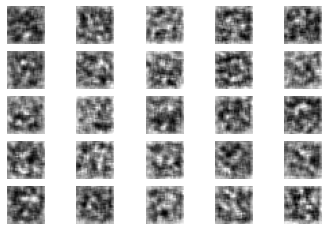

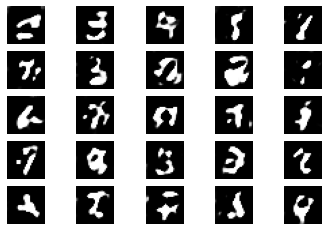

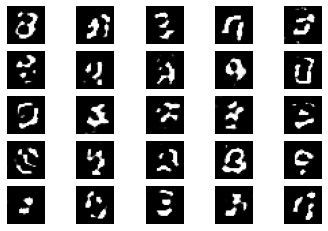

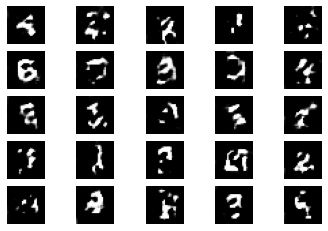

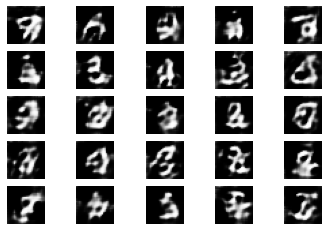

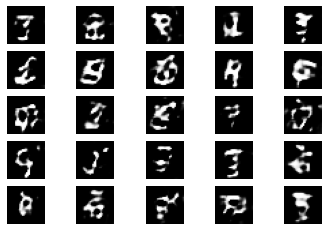

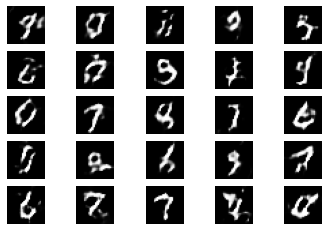

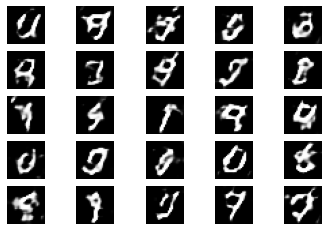

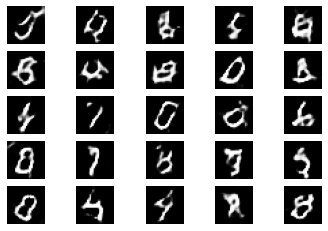

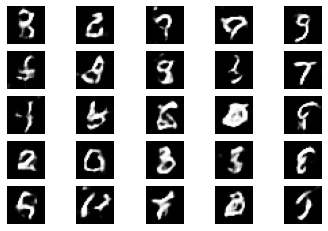

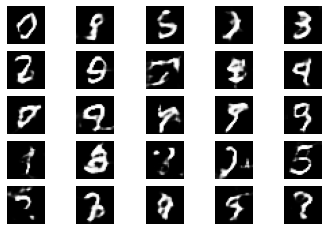

In [19]:
gan_train(2001, 32, 200)